In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'


## The Nasa Ames Dataset
In this lab, an application from machining is investigated. Within machining, one of the main challenges is the prediction of the tool condition, which wears down throughout usage. Thus, a smart prediction approach is needed, capable of forecasting the tool's condition during machining. This way, the tool can be exchanged once it reaches its end of life and expensive tool breakage can be avoided (predicitive maintenance).

UC Berkley provided a dataset through the [NASA Ames repository](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/) containing data for such a usecase, which will be analyzed in this exercise. 
 No. 3: Milling Data Set

The data in this set represents experiments from runs on a milling machine under various operating conditions. Data sampled by three different types of sensors (acoustic emission sensor, vibration sensor, current sensor) were acquired at several positions.

The experiments were carried out on a milling machine for different speeds, feeds, and depths of cut. Therefor selected parameters were chosen according to industrial applicability and recommended manufacturer’s settings. Thus, the cutting speed was set to 200 m/min. Two different depths of cut were chosen, 1.5 mm and 0.75 mm. Also, two feeds were taken, 0.5 mm/rev and 0.25 mm/rev. Two types of material, cast iron and stainless steel, were used. These choices equal 8 different settings. All experiments were done a second time with the same parameters with a second set of inserts. 
In total there were 16 different cases with varying number of runs (dependent on degree of flank wear), as shown in the table below.

|Case|	Depth of Cut|	Feed|	Material|
|-:|:-|:-|:-|
|1	|1.5|	0.5|	1 – cast iron|
|2	|0.75|	0.5|	1 – cast iron|
|3	|0.75|	0.25|	1 – cast iron|
|4	|1.5|	0.25|	1 – cast iron|
|5	|1.5|	0.5	|2 – steel|
|6	|1.5|	0.25|	2 – steel|
|7	|0.75|	0.25|	2 – steel|
|8	|0.75|	0.5|	2 – steel|
|9	|1.5|	0.5|	1 – cast iron|
|10|	1.5|	0.25|	1 – cast iron|
|11	|0.75|	0.25|	1 – cast iron|
|12	|0.75|	0.5|	1 – cast iron|
|13	|0.75|	0.25|	2 – steel|
|14	|0.75|	0.5|	2 – steel|
|15	|1.5|	0.25|	2 – steel|
|16	|1.5|	0.5|	2 – steel|

### Experimental setup
The basic setup encompasses the spindle and the table of the Matsuura machining center MC-510V. An acoustic emission sensor and a vibration sensor are each mounted to the table and the spindle of the machining center. The acoustic emission sensor is glued to a custom-made base which in turn is attached to the clamp bracket. The layout of the sensors on the clamping device is shown in the figure below.

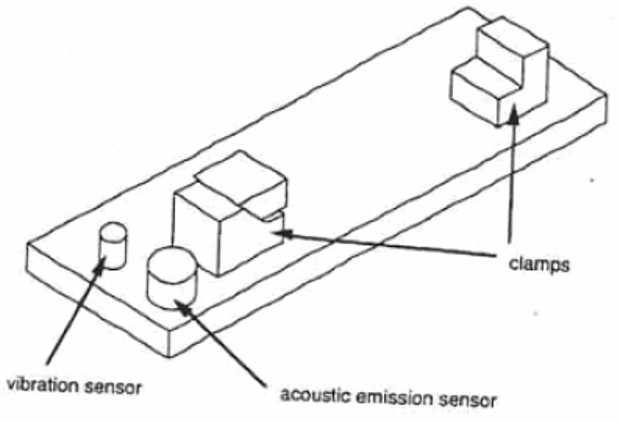



Also mounted on the clamping device on the table is a vibration sensor (accelerometer). 
The same vibration sensor that is mounted on the table is also attached to the spindle into a preexisting threaded hole close to the tool.
A current sensor which uses the same phase of the spindle motor current is fed into the cable connector.

The signals from all sensors are amplified and filtered, then fed through two RMS before they enter the computer for data acquisition with a sampling rate of 250 Hz. The signal from a spindle motor current sensor is fed into the computer without further processing.

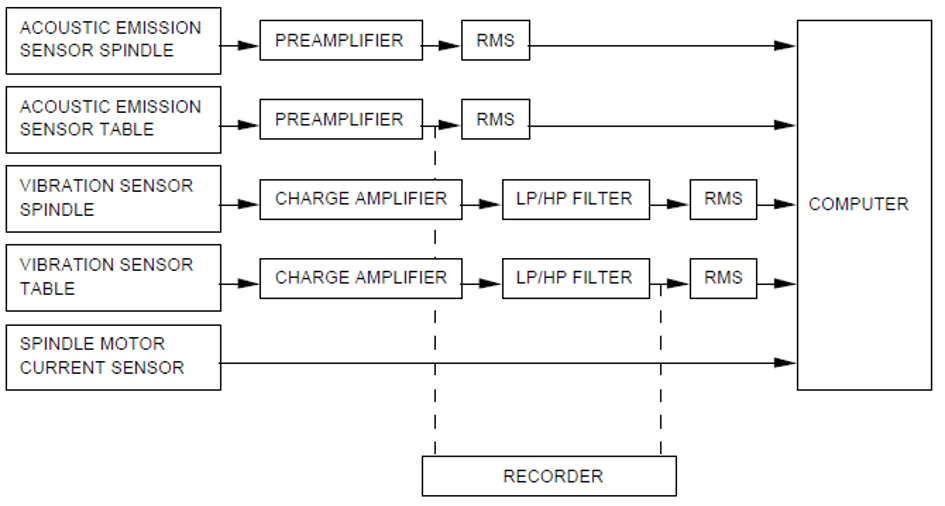


### Useful links

- [Forum on Studon](https://www.studon.fau.de/frm3239687.html)
- [Links related to the exercises](https://www.studon.fau.de/webr2924831.html)

## References
- Introduction: K. Goebel, A. Agogino, Documentation for Mill Data Set
- Structure of this Notebook: [Kißkalt, Dominik, et al. "Streamlining the development of data-driven industrial applications by automated machine learning." Procedia CIRP 93 (2020): 401-406.](https://www.researchgate.net/publication/344370786_Streamlining_the_development_of_data-driven_industrial_applications_by_automated_machine_learning)

In [ ]:
# This cell installs the necessary libraries, thus it only needs to be executed once
!pip install sklearn
!pip install urllib3
!pip install mat4py
!pip install numpy
!pip install scipy
!pip install matplotlib
!pip install tensorflow

In [ ]:
import sklearn
import os
import urllib3
import shutil
import zipfile
import mat4py
from os import listdir
from os.path import isfile, join
import numpy as np
from scipy import signal, fftpack
import matplotlib.pyplot as plt

In [7]:
import sys
sys.path.append('/content/drive/MyDrive/ML4Eng_II_Lab_Timeseries/')
from check import *

In [ ]:
url = 'https://github.com/DomKis/berkeley_milling_data_set/raw/master/mill.mat'
c = urllib3.PoolManager()

with c.request('GET',url, preload_content=False) as resp, open("mill.mat", 'wb') as out_file:
    shutil.copyfileobj(resp, out_file)

resp.release_conn()    

data = mat4py.loadmat("mill.mat") 

In [ ]:
# cast flank wear to float
for item in range(0, data['mill']['VB'].__len__()):
    data['mill']['VB'][item] = float(data['mill']['VB'][item])

data = data['mill']
data_ = []

# create a list with 167 dictionaries corresponding to 167 runs
for index, item in enumerate(data['case']):
    run = {}
    run['case'] = data['case'][index]
    run['run'] = data['run'][index]
    run['VB'] = data['VB'][index]
    run['time'] = data['time'][index]
    run['DOC'] = data['DOC'][index]
    run['feed'] = data['feed'][index]
    run['material'] = data['material'][index]
    run['smcAC'] = [item[0] for item in data['smcAC'][index]]
    run['smcDC'] = [item[0] for item in data['smcDC'][index]]
    run['vib_table'] = [item[0] for item in data['vib_table'][index]]
    run['vib_spindle'] = [item[0] for item in data['vib_spindle'][index]]
    run['AE_table'] = [item[0] for item in data['AE_table'][index]]
    run['AE_spindle'] = [item[0] for item in data['AE_spindle'][index]]
    data_.append(run)
data = data_

In [ ]:
print("The given dataset contains the following runs")
print("Case | Runs: %s" % set([(run['case'], run['run']) for run in data]))
print("Included values for Depth of Cut: %s" % set([run['DOC'] for run in data]))
print("Included values for Feed: %s" % set([run['feed'] for run in data]))
print("Included values for Material: %s" % set([run['material'] for run in data]))  

In [ ]:
con_vars = ['smcDC', 'AE_table', 'AE_spindle', 'vib_spindle', 'vib_table', 'smcAC']

for run in data:
    for con_var in con_vars:
        y = run[con_var]
        y_savgol = signal.savgol_filter(y, 601, 3, deriv=0, delta=1.0, axis=-1, mode='interp', cval=0.0)
        slope = np.diff(y_savgol)
        slope_filtered = signal.savgol_filter(slope, 601, 3, deriv=0, delta=1.0, axis=-1, mode='interp', cval=0.0)

        i_start = None
        i_stop = None
        i_max_slope = np.where(slope_filtered == max(slope_filtered[250:6000]))[0][0]
        i_min_slope = np.where(slope_filtered == min(slope_filtered[i_max_slope:-1]))[0][0]

        for index in range(i_max_slope, len(y)):
            if slope_filtered[index] <= 0.0:
                i_start = index
                break

        for index in range(i_min_slope, 0, -1):
            if slope_filtered[index] >= 0.0:
                i_stop = index
                break

        if (i_stop - i_start) > 1000:
            break

    assert i_start is not None, "Attention: No starting point detected!"
    assert i_stop is not None, "Attention: No stopping point detected!"

    # crop the data
    run['start_steady'] = i_start
    run['stop_steady'] = i_stop

print("Start time of the steady section of run 1: " + str(data[0]['start_steady']))
print("Stop time of the steady section of run 1: " + str(data[0]['stop_steady']))

In [ ]:
con_vars = ['AE_table', 'AE_spindle', 'vib_spindle', 'vib_table', 'smcAC', 'smcDC']
for run in data:
    for con_var in con_vars:
        freqs, time, Zxx = signal.spectrogram(np.array(run[con_var][run['start_steady']:run['stop_steady']]), 
                                              fs=250.0, nperseg=128, noverlap=64)
        run[con_var+'_stft'] = np.transpose(Zxx)

        result = np.abs(fftpack.rfft(np.array(run[con_var][run['start_steady']:run['stop_steady']]), n=1000))
        run[con_var+'_ft'] = result

In [ ]:
print("Some flank wear data point before the interpolation: " + str(data[22]['VB']))
cases = set([item['case'] for item in data])

for case in cases:
    run_indices = [run_index for run_index, run in enumerate(data) if run['case'] == case]
    flank_wears = np.asarray([run['VB'] for run in data[run_indices[0]:run_indices[-1]+1]])

    nans = np.isnan(flank_wears)
    non_nans = np.asarray([not i for i in nans])
    flank_wears[nans] = np.interp(nans.nonzero()[0], non_nans.nonzero()[0], flank_wears[~nans])

    for index, run_index in enumerate(run_indices):
        if nans[index]:
            print('Interpolated VB value for run %i' % (run_index+1))
            data[run_index]['VB'] = flank_wears[index]

print("The data point after the interpolation: " + str(data[22]['VB']))

In [ ]:
cases_to_ignore = [6]
cases = set([item['case'] for item in data])

for case in cases:
    if case in cases_to_ignore:
        continue

    run_indices = [run_index for run_index, run in enumerate(data) if run['case'] == case]
    flank_wears = np.asarray([run['VB'] for run in data[run_indices[0]:run_indices[-1]+1]])
    flank_wears_diffs = np.diff(flank_wears)

    for index, run_index in enumerate(run_indices):
        start_vb = data[run_index]['VB']

        if index < len(run_indices) - 1:
            end_vb = data[run_index+1]['VB']
        else:
            end_vb = data[run_index]['VB'] + flank_wears_diffs[-1]

        flank_wear_con = np.linspace(start_vb, end_vb, (len(data[run_index]['smcAC_stft'])+1))  # smcAC_stft randomly chosen as frequency signal, in PyCharm as parameter con_var
        data[run_index]['VB_con'] = flank_wear_con[0:-1]

print("Continuous, interpolated flank wear of the first run: " + str(list(data[0]['VB_con'])))

In [ ]:
lst = range(1, len(data)+1)
runs_to_remove = [18, 22, 23, 94, 95, 106, 116, 119, 120, 127]  # list of deviant runs
runs_to_keep = [item for item in lst if item not in runs_to_remove]
data = [item for index, item in enumerate(data) if (index+1) in runs_to_keep]
print("Deviant runs: " + str(runs_to_remove))

In [ ]:
data = [run for run in data if run['material'] == 1]

In [ ]:
X = []
y = []

con_vars = ['AE_table_stft', 'AE_spindle_stft', 
            'vib_spindle_stft', 'vib_table_stft', 
            'smcAC_stft', 'smcDC_stft']
dis_vars = ['DOC', 'feed', 'material']

for index, run in enumerate(data):
    length = len(run['vib_table_stft'])
    con = np.hstack([run[key] for key in con_vars])
    dis = np.transpose(np.vstack([[run[key]] * length for key in dis_vars]))


    comb = np.hstack([con, dis])

    X.append(comb)
    y.append(run['VB_con'])

_X = X[0]
_y = y[0]

for index, item in enumerate(X[1:]):
    _X = np.vstack([_X, item])
    _y = np.hstack([_y, y[index+1]])

print(_X.shape)
print(_y.shape)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=11, copy=True, 
          whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=2)
_X = pca.fit_transform(_X)

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

data_gen = TimeseriesGenerator(_X, _y, """Your code goes here""")

quality_gate_01(data_gen, _X)

In [ ]:
plt.figure(figsize=(12,4), dpi=150)
plt.plot(np.arange(len(_y))[:int(0.6*len(_y))], 
         _y[:int(0.6*len(_y))], 
         label="training")
plt.plot(np.arange(len(_y))[int(0.6*len(_y)):int(0.8*len(_y))], 
         _y[int(0.6*len(_y)):int(0.8*len(_y))], 
         label="validation")
plt.plot(np.arange(len(_y))[int(0.8*len(_y)):], 
         _y[int(0.8*len(_y)):], 
         label="testing")
plt.ylabel("Tool condition")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Training data generator
data_gen_training = TimeseriesGenerator(_X, _y, """Your code goes here""")
# Validation data generator
data_gen_validation = TimeseriesGenerator(_X, _y, """Your code goes here""")
# Testing data generator
data_gen_testing = TimeseriesGenerator(_X, _y, """Your code goes here""")

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
"""Your code goes here"""

print(quality_gate_02(model), "\n")
model.compile(optimizer = keras.optimizers.Adam(), loss="mse")
model.summary()

In [ ]:
def train_model(model, data_gen_training, data_gen_validation, epochs=10):
    es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

    history = model.fit(
        data_gen_training,
        validation_data=data_gen_validation,
        epochs=epochs,
        callbacks=[es_callback]
    )
    return model, history

def score_model(model, data_gen_testing, data_gen):
    from sklearn.metrics import r2_score, mean_squared_error

    y_test = list()
    for i in data_gen_testing:
        y_test.append(i[1])

    y_all = list()
    for i in data_gen:
        y_all.append(i[1])

    y_test_pred = model.predict(data_gen_testing)
    y_all_pred = model.predict(data_gen)

    print("Final Test Evaluation Score R2 %f" % r2_score(y_test, y_test_pred))
    print("Final Completet Data Set Evaluation Score R2 %f" % r2_score(y_all, y_all_pred))
    print("Final Test Evaluation Score RMSE %f" % mean_squared_error(y_test, y_test_pred))
    print("Final Completet Data Set Evaluation Score RMSE %f" % mean_squared_error(y_all, y_all_pred))
    return y_test_pred, y_all_pred
    
def visualize_predictions(_y, y_all_pred):
    plt.figure(figsize=(12,4), dpi=150)
    plt.plot(np.arange(len(_y))[:int(0.6*len(_y))], 
             _y[:int(0.6*len(_y))], 
             label="training")
    plt.plot(np.arange(len(_y))[int(0.6*len(_y)):int(0.8*len(_y))], 
             _y[int(0.6*len(_y)):int(0.8*len(_y))], 
             label="validation")
    plt.plot(np.arange(len(_y))[int(0.8*len(_y)):], 
             _y[int(0.8*len(_y)):], 
             label="testing")
    plt.plot(y_all_pred, label="predicted VB", color=(51/255, 51/255, 51/255), linewidth=0.75)
    plt.ylabel("Tool condition")
    plt.grid()
    plt.legend()
    plt.show()

Now, lets train the model and investigate the results

In [ ]:
model, _ = train_model(model, data_gen_training, data_gen_validation, epochs = 10)
y_test_pred, y_all_pred = score_model(model, data_gen_testing, data_gen)
visualize_predictions(_y, y_all_pred)